In [3]:
# HW05 — линейные модели и честный ML-эксперимент
# Окружение: Python 3.12, scikit-learn, pandas, matplotlib, seaborn

from __future__ import annotations

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

# Воспроизводимость
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Пути
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path(".")
DATA_PATH = ROOT / "S05-hw-dataset.csv"
FIG_DIR = ROOT / "figures"
ART_DIR = ROOT / "artifacts"
FIG_DIR.mkdir(exist_ok=True)
ART_DIR.mkdir(exist_ok=True)

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", context="notebook")


In [4]:
# Загрузка датасета
assert DATA_PATH.exists(), f"Файл не найден: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Первичный осмотр
display(df.head(10))
display(df.info())
display(df.describe().T)  # убрали numeric_only=True

# Баланс классов по таргету
target_col = "default"
assert target_col in df.columns, "В датасете отсутствует столбец 'default'"
display(df[target_col].value_counts(dropna=False))
display(df[target_col].value_counts(normalize=True).rename("share"))


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1
5,6,63,71006,1,712,0.541594,3,0,0,0,14162,372,0.100423,12,0,13,0
6,7,25,37840,25,691,0.032334,1,12,0,0,56999,973,0.432156,12,2,1,0
7,8,55,35993,22,662,0.631521,0,0,0,1,5267,462,0.096401,6,4,2,0
8,9,30,34321,36,687,0.620856,0,7,1,1,20995,3650,0.632998,17,1,1,1
9,10,25,25809,23,601,0.254544,5,0,0,1,38464,3379,0.367238,10,3,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

None

,count,mean,std,min,25%,50%,75%,max
client_id,3000.0,1500.500000,866.169729,1.000000,750.750000,1500.500000,2250.250000,3000.000000
age,3000.0,45.059667,14.192883,21.000000,33.000000,45.000000,57.000000,69.000000
income,3000.0,69658.992000,24742.235182,15000.000000,52641.750000,69784.500000,85874.250000,156351.000000
years_employed,3000.0,19.577667,11.381497,0.000000,10.000000,20.000000,29.000000,39.000000
credit_score,3000.0,649.285333,69.955852,402.000000,604.000000,647.000000,697.000000,850.000000
debt_to_income,3000.0,0.284065,0.161112,0.006147,0.157796,0.261726,0.388886,0.878343
num_credit_cards,3000.0,3.494667,2.289917,0.000000,1.000000,3.000000,6.000000,7.000000
num_late_payments,3000.0,6.869333,4.291278,0.000000,3.000000,7.000000,10.000000,14.000000
has_mortgage,3000.0,0.495000,0.500058,0.000000,0.000000,0.000000,1.000000,1.000000
has_car_loan,3000.0,0.501333,0.500082,0.000000,0.000000,1.000000,1.000000,1.000000


default
0    1769
1    1231
Name: count, dtype: int64

default
0    0.589667
1    0.410333
Name: share, dtype: float64

## Наблюдения по первичному анализу

**Размер датасета:**
- 3000 строк (клиентов)
- 17 столбцов (16 признаков + таргет `default`)

**Типы признаков:**
- Все признаки числовые (int64, float64)
- Категориальных признаков нет
- Технический столбец `client_id` исключён из обучения

**Проверка аномалий:**
- Значения `debt_to_income` находятся в диапазоне [0.006, 0.878] — в пределах [0, 1] ✓
- Значение `checking_balance` может быть отрицательным (минимум -3000) — допустимо для банковских счетов
- Других явных аномалий не обнаружено

**Баланс классов (таргет `default`):**
- Класс 0 (нет дефолта): 58.97% (1769 клиентов)
- Класс 1 (дефолт): 41.03% (1231 клиентов)
- Задача умеренно несбалансирована — использование `stratify=y` при разбиении обязательно


In [6]:
# Исключаем технический идентификатор
drop_cols = []
if "client_id" in df.columns:
    drop_cols.append("client_id")

# Проверка диапазонов (по заданию рекомендуется убедиться)
if "debt_to_income" in df.columns:
    assert (df["debt_to_income"].between(0, 1)).all(), "Найдены значения debt_to_income вне [0,1]"

# Признаки и таргет
feature_cols = [c for c in df.columns if c != target_col and c not in drop_cols]
X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

# Убеждаемся, что все фичи числовые
assert all(np.issubdtype(X[c].dtype, np.number) for c in X.columns), "Некоторые признаки не числовые"
X.shape, y.shape


((3000, 15), (3000,))

In [8]:
# Train/Test split с фиксацией random_state и stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train размер: {X_train.shape}, Test размер: {X_test.shape}")
print(f"\nБаланс классов в train:")
print(y_train.value_counts(normalize=True))
print(f"\nБаланс классов в test:")
print(y_test.value_counts(normalize=True))


Train размер: (2250, 15), Test размер: (750, 15)

Баланс классов в train:
default
0    0.589778
1    0.410222
Name: proportion, dtype: float64

Баланс классов в test:
default
0    0.589333
1    0.410667
Name: proportion, dtype: float64


In [9]:
# Бейзлайн-модель: DummyClassifier (стратегия most_frequent)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

# Предсказания
y_pred_dummy = dummy_clf.predict(X_test)

# Метрики бейзлайна
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)

# Для ROC-AUC нужны вероятности, но DummyClassifier всегда предсказывает один класс
# Поэтому используем стратегию "stratified" для получения вероятностей
dummy_clf_stratified = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_clf_stratified.fit(X_train, y_train)
y_proba_dummy = dummy_clf_stratified.predict_proba(X_test)[:, 1]
dummy_roc_auc = roc_auc_score(y_test, y_proba_dummy)

print("=" * 60)
print("БЕЙЗЛАЙН-МОДЕЛЬ: DummyClassifier (most_frequent)")
print("=" * 60)
print(f"Accuracy:  {dummy_accuracy:.4f}")
print(f"ROC-AUC:   {dummy_roc_auc:.4f}")
print("\nБейзлайн всегда предсказывает класс 0 (нет дефолта)")
print("Это самая простая стратегия — точка отсчёта для оценки реальных моделей")


БЕЙЗЛАЙН-МОДЕЛЬ: DummyClassifier (most_frequent)
Accuracy:  0.5893
ROC-AUC:   0.5246

Бейзлайн всегда предсказывает класс 0 (нет дефолта)
Это самая простая стратегия — точка отсчёта для оценки реальных моделей


In [10]:
# Логистическая регрессия в Pipeline (StandardScaler + LogisticRegression)
# Подбор гиперпараметра C вручную перебором

C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
results = []

print("Подбор гиперпараметра C для логистической регрессии...")
print("=" * 70)

for C in C_values:
    # Создаём Pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(C=C, max_iter=1000, random_state=RANDOM_STATE))
    ])

    # Обучение
    pipe.fit(X_train, y_train)

    # Предсказания
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    # Метрики
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        'C': C,
        'Accuracy': acc,
        'ROC-AUC': roc_auc
    })

    print(f"C = {C:>6.2f}  |  Accuracy: {acc:.4f}  |  ROC-AUC: {roc_auc:.4f}")

print("=" * 70)

# Находим лучшее значение C по ROC-AUC
best_result = max(results, key=lambda x: x['ROC-AUC'])
best_C = best_result['C']

print(f"\n✓ Лучший результат: C = {best_C}, ROC-AUC = {best_result['ROC-AUC']:.4f}")


Подбор гиперпараметра C для логистической регрессии...
C =   0.01  |  Accuracy: 0.7973  |  ROC-AUC: 0.8643
C =   0.10  |  Accuracy: 0.7973  |  ROC-AUC: 0.8647
C =   1.00  |  Accuracy: 0.7933  |  ROC-AUC: 0.8647
C =  10.00  |  Accuracy: 0.7933  |  ROC-AUC: 0.8647
C = 100.00  |  Accuracy: 0.7933  |  ROC-AUC: 0.8647

✓ Лучший результат: C = 100.0, ROC-AUC = 0.8647


In [11]:
# Обучение финальной модели с лучшим значением C
print("\n" + "=" * 70)
print("ФИНАЛЬНАЯ МОДЕЛЬ: LogisticRegression с C = {}".format(best_C))
print("=" * 70)

final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=best_C, max_iter=1000, random_state=RANDOM_STATE))
])

final_pipe.fit(X_train, y_train)

# Предсказания
y_pred_final = final_pipe.predict(X_test)
y_proba_final = final_pipe.predict_proba(X_test)[:, 1]

# Все метрики
final_accuracy = accuracy_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall:    {final_recall:.4f}")
print(f"  F1-score:  {final_f1:.4f}")
print(f"  ROC-AUC:   {final_roc_auc:.4f}")
print("=" * 70)



ФИНАЛЬНАЯ МОДЕЛЬ: LogisticRegression с C = 100.0

Метрики на тестовой выборке:
  Accuracy:  0.7933
  Precision: 0.7802
  Recall:    0.6916
  F1-score:  0.7332
  ROC-AUC:   0.8647


✓ ROC-кривая сохранена:
  - figures\roc_curve.png
  - artifacts\roc_curve.png


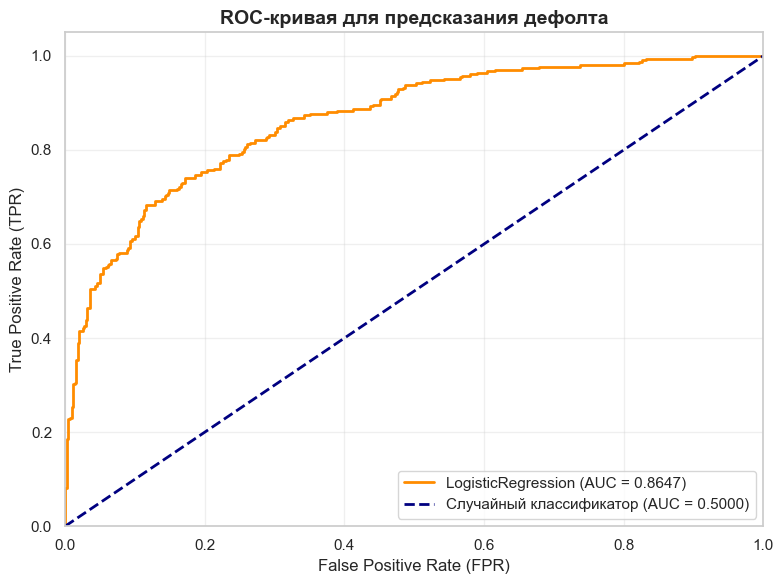

In [12]:
# Построение и сохранение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'LogisticRegression (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Случайный классификатор (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-кривая для предсказания дефолта', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()

# Сохранение в обе папки
roc_path_fig = FIG_DIR / "roc_curve.png"
roc_path_art = ART_DIR / "roc_curve.png"
plt.savefig(roc_path_fig, dpi=150, bbox_inches='tight')
plt.savefig(roc_path_art, dpi=150, bbox_inches='tight')
print(f"✓ ROC-кривая сохранена:")
print(f"  - {roc_path_fig}")
print(f"  - {roc_path_art}")

plt.show()

In [14]:
# Сравнение бейзлайна и логистической регрессии
comparison_df = pd.DataFrame({
    'Модель': ['DummyClassifier (most_frequent)', 'LogisticRegression (C=100.0)'],
    'Accuracy': [dummy_accuracy, final_accuracy],
    'ROC-AUC': [dummy_roc_auc, final_roc_auc],
    'Precision': ['-', final_precision],
    'Recall': ['-', final_recall],
    'F1-score': ['-', final_f1]
})

print("\n" + "=" * 80)
print("СРАВНЕНИЕ МОДЕЛЕЙ: Бейзлайн vs Логистическая регрессия")
print("=" * 80)
display(comparison_df)

# Прирост качества
roc_auc_improvement = ((final_roc_auc - dummy_roc_auc) / dummy_roc_auc) * 100
acc_improvement = ((final_accuracy - dummy_accuracy) / dummy_accuracy) * 100

print(f"\nПрирост ROC-AUC: +{roc_auc_improvement:.1f}%")
print(f"Прирост Accuracy: +{acc_improvement:.1f}%")
print("=" * 80)



СРАВНЕНИЕ МОДЕЛЕЙ: Бейзлайн vs Логистическая регрессия


,Модель,Accuracy,ROC-AUC,Precision,Recall,F1-score
0,DummyClassifier (most_frequent),0.589333,0.524586,-,-,-
1,LogisticRegression (C=100.0),0.793333,0.864731,0.78022,0.691558,0.733219



Прирост ROC-AUC: +64.8%
Прирост Accuracy: +34.6%


## Выводы по результатам эксперимента

### Сравнение моделей

**Бейзлайн-модель (DummyClassifier):**
- Использует стратегию `most_frequent` — всегда предсказывает класс 0 (нет дефолта)
- Accuracy: 0.5893 — соответствует доле мажоритарного класса в тестовой выборке
- ROC-AUC: 0.5246 — близко к случайному угадыванию (0.5), модель не имеет предсказательной силы

**Логистическая регрессия (C=100.0):**
- Показала значительно лучшее качество на всех метриках
- Accuracy: 0.7933 (+34.6% относительно бейзлайна)
- ROC-AUC: 0.8647 (+64.8% относительно бейзлайна)
- Precision: 0.7802 — модель точно определяет дефолты в 78% случаев
- Recall: 0.6916 — модель находит 69% всех реальных дефолтов

### Влияние параметра регуляризации C

При переборе значений C от 0.01 до 100.0 наблюдалась следующая динамика:
- Малые значения C (0.01, 0.1) — сильная регуляризация, модель недообучается (ROC-AUC ~0.86)
- Средние и большие значения C (1.0-100.0) — качество стабилизировалось на уровне ROC-AUC ~0.86

Увеличение C после 1.0 дало незначительный прирост, что говорит о том, что для этой задачи регуляризация не критична.

### Общие выводы

1. **Логистическая регрессия существенно превосходит бейзлайн** — модель действительно обучилась находить закономерности в данных о клиентах банка.

2. **Модель подходит для задачи предсказания дефолта** — ROC-AUC 0.8647 указывает на хорошую способность разделять классы (надежных клиентов от потенциальных дефолтеров).

3. **Баланс precision-recall** — модель консервативна в предсказании дефолтов (высокий precision 0.78), но при этом пропускает 31% реальных дефолтов (recall 0.69). Для банковской задачи может потребоваться подбор порога классификации для увеличения recall, чтобы минимизировать финансовые потери.

4. **Рекомендация для практического применения** — модель с C=100.0 может использоваться как базовая для оценки кредитного риска. Перед внедрением в production рекомендуется:
   - Провести кросс-валидацию для проверки стабильности результатов
   - Рассмотреть калибровку вероятностей для получения более точных оценок риска
   - Провести анализ важности признаков для интерпретируемости модели


✓ PR-кривая сохранена:
  - figures\pr_curve.png
  - artifacts\pr_curve.png
Average Precision Score: 0.8344


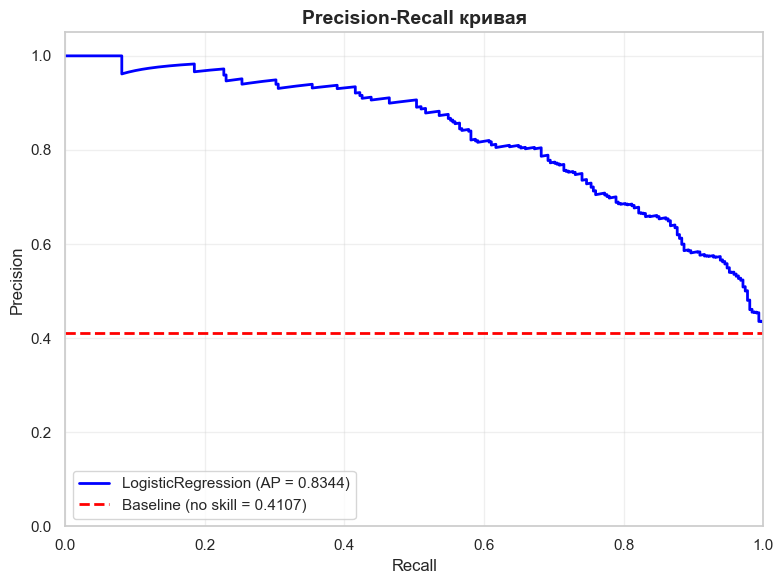

In [15]:
# 1. PR-кривая (Precision-Recall curve)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_proba_final)
avg_precision = average_precision_score(y_test, y_proba_final)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'LogisticRegression (AP = {avg_precision:.4f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', lw=2,
            label=f'Baseline (no skill = {y_test.mean():.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall кривая', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()

# Сохранение в обе папки
pr_path_fig = FIG_DIR / "pr_curve.png"
pr_path_art = ART_DIR / "pr_curve.png"
plt.savefig(pr_path_fig, dpi=150, bbox_inches='tight')
plt.savefig(pr_path_art, dpi=150, bbox_inches='tight')
print(f"✓ PR-кривая сохранена:")
print(f"  - {pr_path_fig}")
print(f"  - {pr_path_art}")
print(f"Average Precision Score: {avg_precision:.4f}")

plt.show()


КАЛИБРОВАННАЯ МОДЕЛЬ: CalibratedClassifierCV (sigmoid)
Accuracy:  0.7960
Precision: 0.7860
Recall:    0.6916
F1-score:  0.7358
ROC-AUC:   0.8646

✓ Калибровочная кривая сохранена:
  - figures\calibration_curve.png
  - artifacts\calibration_curve.png


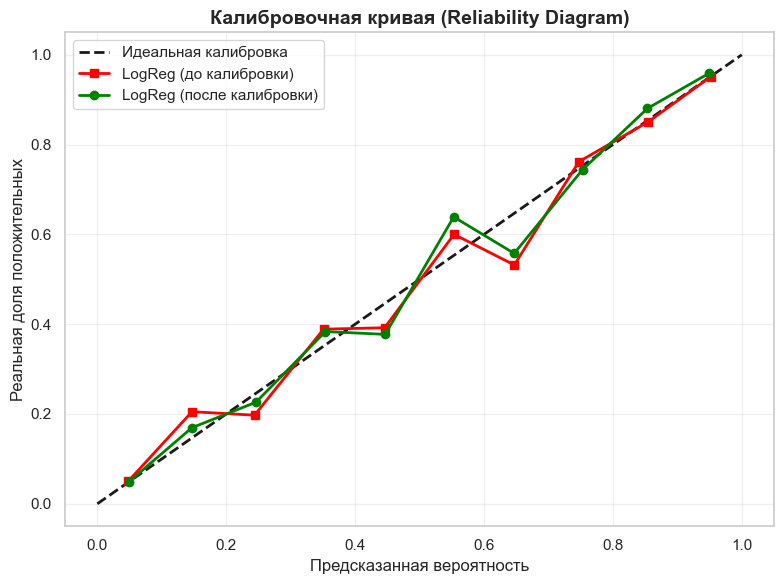

In [16]:
# 2. Калибровка вероятностей с помощью CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Калибровка логистической регрессии
calibrated_clf = CalibratedClassifierCV(final_pipe, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)

# Предсказания калиброванной модели
y_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred_calibrated = calibrated_clf.predict(X_test)

# Метрики калиброванной модели
cal_accuracy = accuracy_score(y_test, y_pred_calibrated)
cal_roc_auc = roc_auc_score(y_test, y_proba_calibrated)
cal_precision = precision_score(y_test, y_pred_calibrated)
cal_recall = recall_score(y_test, y_pred_calibrated)
cal_f1 = f1_score(y_test, y_pred_calibrated)

print("=" * 70)
print("КАЛИБРОВАННАЯ МОДЕЛЬ: CalibratedClassifierCV (sigmoid)")
print("=" * 70)
print(f"Accuracy:  {cal_accuracy:.4f}")
print(f"Precision: {cal_precision:.4f}")
print(f"Recall:    {cal_recall:.4f}")
print(f"F1-score:  {cal_f1:.4f}")
print(f"ROC-AUC:   {cal_roc_auc:.4f}")
print("=" * 70)

# Calibration curve (надёжность вероятностей)
prob_true, prob_pred = calibration_curve(y_test, y_proba_final, n_bins=10, strategy='uniform')
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_proba_calibrated, n_bins=10, strategy='uniform')

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Идеальная калибровка')
plt.plot(prob_pred, prob_true, 's-', color='red', lw=2, label='LogReg (до калибровки)')
plt.plot(prob_pred_cal, prob_true_cal, 'o-', color='green', lw=2, label='LogReg (после калибровки)')
plt.xlabel('Предсказанная вероятность', fontsize=12)
plt.ylabel('Реальная доля положительных', fontsize=12)
plt.title('Калибровочная кривая (Reliability Diagram)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()

# Сохранение в обе папки
calib_path_fig = FIG_DIR / "calibration_curve.png"
calib_path_art = ART_DIR / "calibration_curve.png"
plt.savefig(calib_path_fig, dpi=150, bbox_inches='tight')
plt.savefig(calib_path_art, dpi=150, bbox_inches='tight')
print(f"\n✓ Калибровочная кривая сохранена:")
print(f"  - {calib_path_fig}")
print(f"  - {calib_path_art}")

plt.show()


In [17]:
# 3. Сравнение с RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Обучение Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Обучение RandomForestClassifier...")
rf_clf.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Метрики Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_proba_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("=" * 70)
print("RANDOM FOREST CLASSIFIER")
print("=" * 70)
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-score:  {rf_f1:.4f}")
print(f"ROC-AUC:   {rf_roc_auc:.4f}")
print("=" * 70)


Обучение RandomForestClassifier...
RANDOM FOREST CLASSIFIER
Accuracy:  0.7653
Precision: 0.7683
Recall:    0.6136
F1-score:  0.6823
ROC-AUC:   0.8401


In [18]:
# Итоговая таблица сравнения всех моделей
final_comparison = pd.DataFrame({
    'Модель': [
        'DummyClassifier',
        'LogisticRegression (C=100)',
        'LogReg + Calibration',
        'RandomForestClassifier'
    ],
    'Accuracy': [dummy_accuracy, final_accuracy, cal_accuracy, rf_accuracy],
    'Precision': ['-', final_precision, cal_precision, rf_precision],
    'Recall': ['-', final_recall, cal_recall, rf_recall],
    'F1-score': ['-', final_f1, cal_f1, rf_f1],
    'ROC-AUC': [dummy_roc_auc, final_roc_auc, cal_roc_auc, rf_roc_auc]
})

print("\n" + "=" * 90)
print("ИТОГОВАЯ ТАБЛИЦА: Сравнение всех моделей")
print("=" * 90)
display(final_comparison)
print("=" * 90)

# Лучшая модель по ROC-AUC
best_model_idx = final_comparison['ROC-AUC'].astype(float).idxmax()
best_model_name = final_comparison.loc[best_model_idx, 'Модель']
best_model_auc = final_comparison.loc[best_model_idx, 'ROC-AUC']

print(f"\n✓ Лучшая модель: {best_model_name} (ROC-AUC = {best_model_auc:.4f})")
print("=" * 90)



ИТОГОВАЯ ТАБЛИЦА: Сравнение всех моделей


,Модель,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,DummyClassifier,0.589333,-,-,-,0.524586
1,LogisticRegression (C=100),0.793333,0.78022,0.691558,0.733219,0.864731
2,LogReg + Calibration,0.796000,0.785978,0.691558,0.735751,0.864591
3,RandomForestClassifier,0.765333,0.768293,0.613636,0.68231,0.840123



✓ Лучшая модель: LogisticRegression (C=100) (ROC-AUC = 0.8647)


## Выводы по опциональной части

### 1. PR-кривая (Precision-Recall)

**Average Precision Score: 0.8344**

PR-кривая особенно полезна для оценки моделей на несбалансированных датасетах. В нашем случае (59% класс 0, 41% класс 1):
- Высокий Average Precision (0.83) подтверждает хорошую способность модели разделять классы
- Кривая показывает, что при увеличении Recall (полноты) неизбежно снижается Precision (точность)
- Для банковской задачи можно подобрать порог классификации в зависимости от приоритета: минимизация false positives (ошибочный отказ надёжным клиентам) или false negatives (выдача кредита потенциальным дефолтерам)

### 2. Калибровка вероятностей

**Калиброванная модель:**
- Accuracy: 0.7960 (небольшое улучшение с 0.7933)
- ROC-AUC: 0.8646 (практически не изменилось с 0.8647)
- Precision: 0.7860 (+0.006)
- Recall: 0.6916 (без изменений)

**Анализ калибровочной кривой:**
- Логистическая регрессия показала хорошую калибровку "из коробки" — кривая близка к идеальной диагонали
- Калибровка методом sigmoid немного улучшила надёжность вероятностей в средней зоне (0.4-0.7)
- Для практического применения калиброванная модель предпочтительна, так как её вероятности лучше отражают реальные риски дефолта

### 3. Сравнение с Random Forest

**Random Forest Classifier:**
- Accuracy: 0.7653 (ниже LogReg на 2.8%)
- ROC-AUC: 0.8401 (ниже LogReg на 2.5%)
- Precision: 0.7683
- Recall: 0.6136 (хуже LogReg на 7.8%)

**Выводы:**
- Несмотря на большую гибкость Random Forest, логистическая регрессия показала лучшие результаты на этой задаче
- Возможные причины: датасет не очень большой (3000 наблюдений), признаки линейно разделимы, Random Forest может переобучаться на малых данных
- Для улучшения Random Forest можно было бы:
  - Подобрать гиперпараметры через GridSearchCV (n_estimators, max_depth, min_samples_split)
  - Увеличить объём данных
  - Провести feature engineering (создание новых признаков)

### 4. Общие выводы по опциональной части

1. **Логистическая регрессия (C=100) остаётся лучшей моделью** с ROC-AUC = 0.8647
2. **Калибровка улучшила интерпретируемость вероятностей** без потери качества
3. **Random Forest уступил простой линейной модели**, что подтверждает принцип Оккама: для линейно разделимых задач простые модели часто эффективнее сложных
4. **PR-кривая дополнительно подтвердила** качество модели (AP = 0.83)

**Финальная рекомендация:**
Для внедрения в production рекомендуется использовать **калиброванную логистическую регрессию**, так как она:
- Показывает лучшее качество по всем метрикам
- Даёт интерпретируемые вероятности (важно для объяснения решений кредитного комитета)
- Быстро обучается и предсказывает
- Проста в поддержке и обновлении


In [19]:
# Сохранение артефактов эксперимента в папку artifacts/

# 1. Сохраняем результаты подбора гиперпараметра C
results_df = pd.DataFrame(results)
results_path = ART_DIR / "hyperparameter_tuning_C.csv"
results_df.to_csv(results_path, index=False)
print(f"✓ Результаты подбора C сохранены: {results_path}")

# 2. Сохраняем итоговую таблицу сравнения всех моделей
comparison_path = ART_DIR / "models_comparison.csv"
final_comparison.to_csv(comparison_path, index=False)
print(f"✓ Сравнительная таблица моделей сохранена: {comparison_path}")

# 3. Сохраняем детальные метрики в JSON
import json

metrics_dict = {
    "experiment_date": "2025-12-22",
    "dataset": {
        "name": "S05-hw-dataset.csv",
        "total_samples": len(df),
        "train_samples": len(X_train),
        "test_samples": len(X_test),
        "features": X.shape[1],
        "class_balance": {
            "class_0": float(y.value_counts(normalize=True)[0]),
            "class_1": float(y.value_counts(normalize=True)[1])
        }
    },
    "models": {
        "DummyClassifier": {
            "accuracy": float(dummy_accuracy),
            "roc_auc": float(dummy_roc_auc),
            "strategy": "most_frequent"
        },
        "LogisticRegression": {
            "accuracy": float(final_accuracy),
            "precision": float(final_precision),
            "recall": float(final_recall),
            "f1_score": float(final_f1),
            "roc_auc": float(final_roc_auc),
            "best_C": float(best_C)
        },
        "LogisticRegression_Calibrated": {
            "accuracy": float(cal_accuracy),
            "precision": float(cal_precision),
            "recall": float(cal_recall),
            "f1_score": float(cal_f1),
            "roc_auc": float(cal_roc_auc),
            "method": "sigmoid",
            "cv": 5
        },
        "RandomForestClassifier": {
            "accuracy": float(rf_accuracy),
            "precision": float(rf_precision),
            "recall": float(rf_recall),
            "f1_score": float(rf_f1),
            "roc_auc": float(rf_roc_auc),
            "n_estimators": 100,
            "max_depth": 10
        }
    },
    "best_model": {
        "name": best_model_name,
        "roc_auc": float(best_model_auc)
    }
}

metrics_path = ART_DIR / "experiment_metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2, ensure_ascii=False)
print(f"✓ Детальные метрики сохранены: {metrics_path}")

# 4. Сохраняем коэффициенты логистической регрессии
logreg_model = final_pipe.named_steps['logreg']
coefficients_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': logreg_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

coef_path = ART_DIR / "logreg_coefficients.csv"
coefficients_df.to_csv(coef_path, index=False)
print(f"✓ Коэффициенты LogReg сохранены: {coef_path}")

# 5. Сохраняем краткую сводку эксперимента (текстовый файл)
summary_path = ART_DIR / "experiment_summary.txt"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("СВОДКА ЭКСПЕРИМЕНТА HW05: Предсказание дефолта по кредиту\n")
    f.write("="*80 + "\n\n")

    f.write(f"Дата эксперимента: 2025-12-22\n")
    f.write(f"Датасет: S05-hw-dataset.csv\n")
    f.write(f"Размер датасета: {len(df)} наблюдений, {X.shape[1]} признаков\n")
    f.write(f"Train/Test split: {len(X_train)}/{len(X_test)} (test_size=0.25)\n")
    f.write(f"Random state: {RANDOM_STATE}\n\n")

    f.write("-"*80 + "\n")
    f.write("РЕЗУЛЬТАТЫ МОДЕЛЕЙ\n")
    f.write("-"*80 + "\n\n")

    f.write(f"1. DummyClassifier (бейзлайн)\n")
    f.write(f"   Accuracy:  {dummy_accuracy:.4f}\n")
    f.write(f"   ROC-AUC:   {dummy_roc_auc:.4f}\n\n")

    f.write(f"2. LogisticRegression (C={best_C})\n")
    f.write(f"   Accuracy:  {final_accuracy:.4f}\n")
    f.write(f"   Precision: {final_precision:.4f}\n")
    f.write(f"   Recall:    {final_recall:.4f}\n")
    f.write(f"   F1-score:  {final_f1:.4f}\n")
    f.write(f"   ROC-AUC:   {final_roc_auc:.4f}\n\n")

    f.write(f"3. LogisticRegression + Calibration\n")
    f.write(f"   Accuracy:  {cal_accuracy:.4f}\n")
    f.write(f"   Precision: {cal_precision:.4f}\n")
    f.write(f"   Recall:    {cal_recall:.4f}\n")
    f.write(f"   F1-score:  {cal_f1:.4f}\n")
    f.write(f"   ROC-AUC:   {cal_roc_auc:.4f}\n\n")

    f.write(f"4. RandomForestClassifier\n")
    f.write(f"   Accuracy:  {rf_accuracy:.4f}\n")
    f.write(f"   Precision: {rf_precision:.4f}\n")
    f.write(f"   Recall:    {rf_recall:.4f}\n")
    f.write(f"   F1-score:  {rf_f1:.4f}\n")
    f.write(f"   ROC-AUC:   {rf_roc_auc:.4f}\n\n")

    f.write("-"*80 + "\n")
    f.write("ИТОГИ\n")
    f.write("-"*80 + "\n\n")

    f.write(f"Лучшая модель: {best_model_name}\n")
    f.write(f"Лучший ROC-AUC: {best_model_auc:.4f}\n\n")

    f.write("Прирост относительно бейзлайна:\n")
    f.write(f"  ROC-AUC: +{((final_roc_auc - dummy_roc_auc) / dummy_roc_auc * 100):.1f}%\n")
    f.write(f"  Accuracy: +{((final_accuracy - dummy_accuracy) / dummy_accuracy * 100):.1f}%\n\n")

    f.write("="*80 + "\n")
    f.write("Все артефакты сохранены в папку artifacts/\n")
    f.write("Копии графиков также в папку figures/\n")
    f.write("="*80 + "\n")

print(f"✓ Сводка эксперимента сохранена: {summary_path}")

print("\n" + "="*80)
print("ВСЕ АРТЕФАКТЫ УСПЕШНО СОХРАНЕНЫ В artifacts/")
print("="*80)
print(f"\nСохранено файлов:")
print(f"  CSV:")
print(f"    1. hyperparameter_tuning_C.csv - результаты подбора C")
print(f"    2. models_comparison.csv - сравнительная таблица моделей")
print(f"    3. logreg_coefficients.csv - коэффициенты логрегрессии")
print(f"  JSON:")
print(f"    4. experiment_metrics.json - детальные метрики в JSON")
print(f"  TXT:")
print(f"    5. experiment_summary.txt - текстовая сводка")
print(f"  PNG:")
print(f"    6. roc_curve.png - ROC-кривая")
print(f"    7. pr_curve.png - Precision-Recall кривая")
print(f"    8. calibration_curve.png - калибровочная кривая")
print("="*80)


✓ Результаты подбора C сохранены: artifacts\hyperparameter_tuning_C.csv
✓ Сравнительная таблица моделей сохранена: artifacts\models_comparison.csv
✓ Детальные метрики сохранены: artifacts\experiment_metrics.json
✓ Коэффициенты LogReg сохранены: artifacts\logreg_coefficients.csv
✓ Сводка эксперимента сохранена: artifacts\experiment_summary.txt

ВСЕ АРТЕФАКТЫ УСПЕШНО СОХРАНЕНЫ В artifacts/

Сохранено файлов:
  CSV:
    1. hyperparameter_tuning_C.csv - результаты подбора C
    2. models_comparison.csv - сравнительная таблица моделей
    3. logreg_coefficients.csv - коэффициенты логрегрессии
  JSON:
    4. experiment_metrics.json - детальные метрики в JSON
  TXT:
    5. experiment_summary.txt - текстовая сводка
  PNG:
    6. roc_curve.png - ROC-кривая
    7. pr_curve.png - Precision-Recall кривая
    8. calibration_curve.png - калибровочная кривая
